In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from itertools import combinations

In [2]:
n_features = 2

# Generate synthetic data with the specified parameters
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=2, n_redundant=0, random_state=3471)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Create a Logistic Regression classifier
logistic_classifier = LogisticRegression(penalty=None)

# Train the classifier on the training data
logistic_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_classifier.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate log loss on the test data
test_loss = log_loss(y_test, y_pred)

print(f"Test Loss: {test_loss:.4f}")

Accuracy: 90.00%
Test Loss: 3.6044


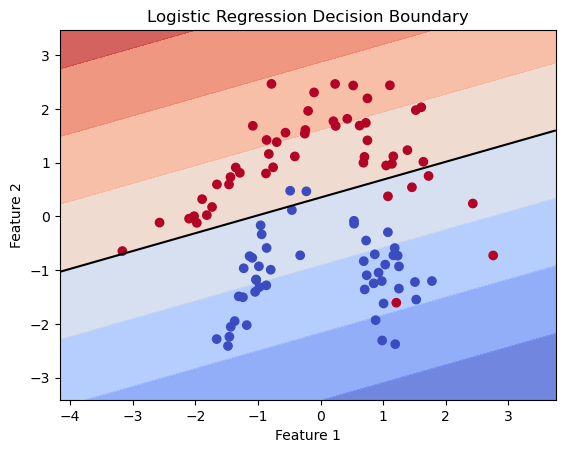

In [3]:
if n_features == 2:
    # Plot the decision boundary
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                        np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
    Z = logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.contour(xx, yy, Z, colors='black', linestyles='-', levels=[0])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Logistic Regression Decision Boundary')
    plt.show()
else:
    from sklearn.decomposition import PCA

    # Reduce dimensionality using PCA to 2 components
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a mesh grid for the reduced feature space
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = logistic_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary in the reduced 2D space
    plt.contour(xx, yy, Z, colors='black', linestyles='--')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, marker='o')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Logistic Regression Decision Boundary (Reduced to 2D)')
    plt.show()


In [4]:
def brute_force_removal(original_logistic_classifier, X_train, y_train, X_test, y_test, fixed_test_point_index, max_size):
	# Initialize variables to keep track of the best subset and loss difference for parameter changes
	best_subset_fix_test = np.full((max_size), None)
	best_reduced_Z_fix_test = np.full((max_size), None)

	## Fixed test point
	fixed_test_point = np.hstack((1, X_test[fixed_test_point_index]))
	
	original_score = np.dot(np.hstack((original_logistic_classifier.intercept_, original_logistic_classifier.coef_[0])), fixed_test_point)
	
	# Loop over different subset sizes from 1 to max_size
	for subset_size in range(1, max_size + 1):
		# Generate all combinations of subsets of the current size
		subset_combinations = combinations(range(X_train.shape[0]), subset_size)

		max_score_difference = -float("inf")

		for subset_to_remove in subset_combinations:
			# Create a new training set without the selected data points
			reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
			reduced_y_train = np.delete(y_train, subset_to_remove, axis=0)

			# Train a Logistic Regression classifier on the reduced training set
			reduced_logistic_classifier = LogisticRegression(penalty=None)

			reduced_logistic_classifier.fit(reduced_X_train, reduced_y_train)

			# Make inference
			reduced_score = np.dot(np.hstack((reduced_logistic_classifier.intercept_, reduced_logistic_classifier.coef_[0])), fixed_test_point)

			# Calculate the difference in predicted probabilities
			score_difference = reduced_score - original_score

			# Update if the current subset induces the maximum change in test loss
			if score_difference > max_score_difference:
				max_score_difference = score_difference
				best_subset_fix_test[subset_size-1] = subset_to_remove
				best_reduced_Z_fix_test[subset_size-1] = reduced_logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

	return [best_subset_fix_test, best_reduced_Z_fix_test]

In [5]:
max_size = 3
fixed_test_point_index = 0
parameter = brute_force_removal(logistic_classifier, X_train, y_train, X_test, y_test, fixed_test_point_index, max_size)

Best Subset of Removed Data Points for Parameter Changes with Size 1: (6,)


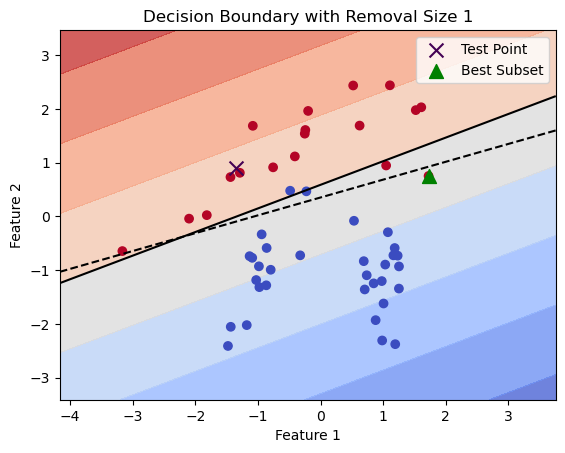

Best Subset of Removed Data Points for Parameter Changes with Size 2: (29, 46)


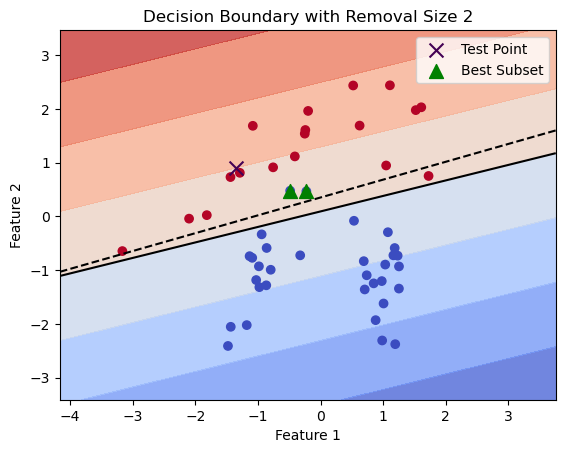

Best Subset of Removed Data Points for Parameter Changes with Size 3: (6, 25, 29)


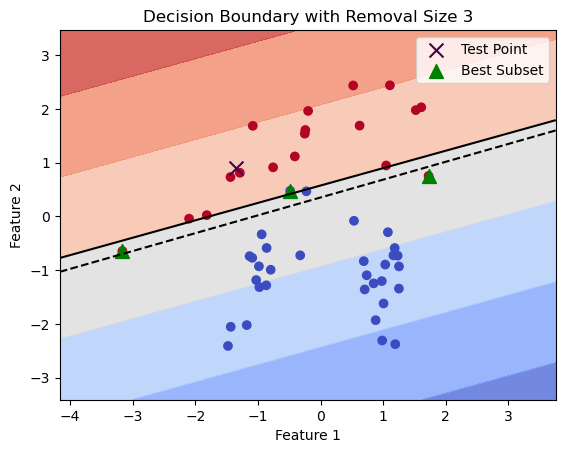

In [6]:
for subset_size in range(1, max_size + 1):
	print(f"Best Subset of Removed Data Points for Parameter Changes with Size {subset_size}: {parameter[0][subset_size-1]}")

	# Plot the decision boundary of the original model and the reduced model, and mark the test point
	plt.figure()

	# Plot the decision boundary of the reduced model (solid line)
	plt.contourf(xx, yy, parameter[1][subset_size-1], cmap=plt.cm.coolwarm, alpha=0.8)
	plt.contour(xx, yy, parameter[1][subset_size-1], colors='black', linestyles='-', levels=[0])

	# Plot the decision boundary of the original model (dashed line)
	original_Z = logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
	plt.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

	# Mark the dataset points with a marker ('o' symbol)
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')

	# Mark the test point with a marker ('x' symbol)
	fixed_test_point = X_test[fixed_test_point_index]
	plt.scatter(fixed_test_point[0], fixed_test_point[1], c=y_test[fixed_test_point_index], marker='x', s=100, label="Test Point")
	
	# Mark the best subset of removed data points with a different marker ('^' symbol)
	best_subset_points = np.take(X_train, parameter[0][subset_size-1], axis=0).reshape(-1, 2)
	plt.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='g', marker='^', s=100, label="Best Subset")

	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title(f'Decision Boundary with Removal Size {subset_size}')
	plt.legend()
	plt.show()

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression_IWLS(X, y, max_iters=100, tolerance=1e-6):
    n_samples, n_features = X.shape
    X = np.hstack((np.ones((n_samples, 1)), X))  # Add a column of ones for the intercept

    # Initialize coefficients, including the intercept
    coef = np.zeros(n_features + 1)
    prev_coef = coef.copy()

    for iteration in range(max_iters):
        p = sigmoid(np.dot(X, coef))
        w = p * (1 - p)  # Calculate weights based on the current predictions

        # Perform a weighted least squares update
        X_weighted = X.T * w
        Hessian = np.dot(X_weighted, X)
        gradient = np.dot(X.T, y - p)
        coef += np.linalg.solve(Hessian, gradient)

        # Check for convergence
        if np.allclose(coef, prev_coef, atol=tolerance):
            break

        prev_coef = coef.copy()
    
    return coef

def calculate_influence(X_train, X_test, coef, fixed_test_point_index, leverage=False):
    n_samples = X_train.shape[0]
    influences = np.zeros(n_samples)
    X = np.hstack((np.ones((n_samples, 1)), X_train))  # Add a column of ones for the intercept

    # Fixed test point with intercept feature
    fixed_test_point = np.hstack((1, X_test[fixed_test_point_index]))

    # Recover w
    p = sigmoid(np.dot(X, coef))
    w = p * (1 - p)  # Calculate weights based on the current predictions

    N = np.dot(X.T * w, X)
    N_inv = np.linalg.inv(N)
    
    influences = w * np.dot(np.dot(fixed_test_point, N_inv), X.T * (np.dot(X, coef) - y_train))
    if leverage:
        for i in range(n_samples):
            # Calculate the influence using the provided formula
            influences[i] = influences[i] / (1 - w[i] * np.dot(np.dot(X[i], N_inv), X[i]))

    return influences

In [8]:
# Create the logistic regression model and fit it
coefficients = logistic_regression_IWLS(X_train, y_train)

# Calculate influences
influences = calculate_influence(X_train, X_test, coefficients, fixed_test_point_index)
top_indices = np.argsort(influences)[-(max_size+3):][::-1]

print(f"Without leverage\n Top {max_size+3} Influential Data Points Estimate: {top_indices}")

# Calculate influences
influences = calculate_influence(X_train, X_test, coefficients, fixed_test_point_index, leverage=True)
top_indices = np.argsort(influences)[-(max_size+3):][::-1]

print(f"With leverage\n Top {max_size+3} Influential Data Points Estimate: {top_indices}")

Without leverage
 Top 6 Influential Data Points Estimate: [29 28 12 32  7 46]
With leverage
 Top 6 Influential Data Points Estimate: [29 28 12 32 46 26]


In [9]:
print(f"IWLS results:\n Intercept: {coefficients[0]}\n Coefficients: {coefficients[1:]}\n")
print(f"Sklearn results:\n Intercept: {logistic_classifier.intercept_[0]}\n Coefficients: {logistic_classifier.coef_[0]}")

IWLS results:
 Intercept: -1.6747943452746623
 Coefficients: [-1.58282618  4.7688618 ]

Sklearn results:
 Intercept: -1.6747877652760734
 Coefficients: [-1.58282688  4.76884952]


In [10]:
# Calculate influences
influences = calculate_influence(X_train, X_test, np.hstack((logistic_classifier.intercept_, logistic_classifier.coef_[0])), fixed_test_point_index)
top_indices = np.argsort(influences)[-(max_size+3):][::-1]

print(f"Without leverage\n Top {max_size+3} Influential Data Points Estimate: {top_indices}")

# Calculate influences
influences = calculate_influence(X_train, X_test, np.hstack((logistic_classifier.intercept_, logistic_classifier.coef_[0])), fixed_test_point_index, leverage=True)
top_indices = np.argsort(influences)[-(max_size+3):][::-1]

print(f"With leverage\n Top {max_size+3} Influential Data Points Estimate: {top_indices}")

Without leverage
 Top 6 Influential Data Points Estimate: [29 28 12 32  7 46]
With leverage
 Top 6 Influential Data Points Estimate: [29 28 12 32 46 26]
